# Overview

1448棟のビルの4種類のメーター（電力、冷水、スチーム、温水）の値を予測するコンペである。

背景としては、エネルギー使用量（4種類のメーターの値）が正確に予測できるようになることで<br>
省エネ投資を活発化させて、環境問題に貢献したいという狙いがある。

ビルの所有者は、ビルのエネルギー効率を改善するような投資を行うことで<br>
エネルギー効率が改善された分、コストを抑えることができる。

# Module

In [1]:
import gc
import sys
import optuna
import datetime
import warnings
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

# Datasets

In [2]:
train = pd.read_csv('../input/ashrae-energy-prediction/train.csv')

print(train.shape)
train.head()

(20216100, 4)


,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


1時間ごとのメータ値を保持するテーブル（学習データ）<br>
・building_id：ビルのID<br>
・meter：0は電力、1は冷水、2はスチーム、3は温水<br>
・timestamp：日付と時刻<br>
・meter_reading：メーターの使用量（目的変数）<br>

In [3]:
test = pd.read_csv('../input/ashrae-energy-prediction/test.csv')

print(test.shape)
test.head()

(41697600, 4)


,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00


1時間ごとのメータ値を保持するテーブル（テストデータ）<br>
・row_id：行のID<br>
・building_id：ビルのID<br>
・meter：0は電力、1は冷水、2はスチーム、3は温水<br>
・timestamp：日付と時刻<br>

In [4]:
usecols = {'site_id', 'timestamp', 'air_temperature', 'dew_temperature'}

In [5]:
weather_train = pd.read_csv('../input/ashrae-energy-prediction/weather_train.csv', usecols=usecols)

print(weather_train.shape)
weather_train.head()

(139773, 4)


,site_id,timestamp,air_temperature,dew_temperature
0,0,2016-01-01 00:00:00,25.0,20.0
1,0,2016-01-01 01:00:00,24.4,21.1
2,0,2016-01-01 02:00:00,22.8,21.1
3,0,2016-01-01 03:00:00,21.1,20.6
4,0,2016-01-01 04:00:00,20.0,20.0


気象情報を保持するテーブル（学習データに対応）<br>
・site_id：ビルの物理的な位置<br>
・timestamp：日付と時刻<br>
・air_temperature：気温<br>
・dew_temperature：湿度<br>
・precip_depth：降水量<br>
・sea_level_pressure：海圧<br>
・wind_direction：風向<br>
・wind_speed：風速<br>

In [6]:
weather_test = pd.read_csv('../input/ashrae-energy-prediction/weather_test.csv', usecols=usecols)

print(weather_test.shape)
weather_test.head()

(277243, 4)


,site_id,timestamp,air_temperature,dew_temperature
0,0,2017-01-01 00:00:00,17.8,11.7
1,0,2017-01-01 01:00:00,17.8,12.8
2,0,2017-01-01 02:00:00,16.1,12.8
3,0,2017-01-01 03:00:00,17.2,13.3
4,0,2017-01-01 04:00:00,16.7,13.3


気象情報を保持するテーブル（テストデータに対応）<br>
・site_id：ビルの物理的な位置<br>
・timestamp：日付と時刻<br>
・air_temperature：気温<br>
・dew_temperature：湿度<br>
・precip_depth：降水量<br>
・sea_level_pressure：海圧<br>
・wind_direction：風向<br>
・wind_speed：風速<br>

In [7]:
usecols = {'site_id', 'building_id', 'primary_use', 'square_feet', 'year_built'}

In [8]:
building = pd.read_csv('../input/ashrae-energy-prediction/building_metadata.csv', usecols=usecols)

print(building.shape)
building.head()

(1449, 5)


,site_id,building_id,primary_use,square_feet,year_built
0,0,0,Education,7432,2008.0
1,0,1,Education,2720,2004.0
2,0,2,Education,5376,1991.0
3,0,3,Education,23685,2002.0
4,0,4,Education,116607,1975.0


ビルの情報を保持するテーブル<br>
・site_id：ビルの物理的な位置<br>
・building_id：ビルのID<br>
・primary_use：使用目的<br>
・square_feet：面積<br>
・year_built：施工した年<br>
・floor_count：階数<br>

# Lags

In [9]:
'''
lag_cols = ['air_temperature', 'dew_temperature']

for i in lag_cols:
    weather_train['DIFF_' + i] = weather_train.groupby(by = ['site_id'])[i].shift(-1)
    weather_train['PREVIOUS_DIFF_' + i] = np.abs(weather_train[i] - weather_train['DIFF_' + i])
    weather_train = weather_train.drop(['DIFF_' + i], axis=1)
    
weather_train.head()
'''

"\nlag_cols = ['air_temperature', 'dew_temperature']\n\nfor i in lag_cols:\n    weather_train['DIFF_' + i] = weather_train.groupby(by = ['site_id'])[i].shift(-1)\n    weather_train['PREVIOUS_DIFF_' + i] = np.abs(weather_train[i] - weather_train['DIFF_' + i])\n    weather_train = weather_train.drop(['DIFF_' + i], axis=1)\n    \nweather_train.head()\n"

In [10]:
'''
lag_cols = ['air_temperature', 'dew_temperature']

for i in lag_cols:
    weather_test['DIFF_' + i] = weather_test.groupby(by = ['site_id'])[i].shift(-1)
    weather_test['PREVIOUS_DIFF_' + i] = np.abs(weather_test[i] - weather_test['DIFF_' + i])
    weather_test = weather_test.drop(['DIFF_' + i], axis=1)
    
weather_test.head()
'''

"\nlag_cols = ['air_temperature', 'dew_temperature']\n\nfor i in lag_cols:\n    weather_test['DIFF_' + i] = weather_test.groupby(by = ['site_id'])[i].shift(-1)\n    weather_test['PREVIOUS_DIFF_' + i] = np.abs(weather_test[i] - weather_test['DIFF_' + i])\n    weather_test = weather_test.drop(['DIFF_' + i], axis=1)\n    \nweather_test.head()\n"

# Join

In [11]:
def reduce_mem_usage(df, use_float16=False):
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [12]:
# train = reduce_mem_usage(train)
# test = reduce_mem_usage(test)

weather_train = reduce_mem_usage(weather_train)
weather_test = reduce_mem_usage(weather_test)

building = reduce_mem_usage(building)

Memory usage of dataframe is 4.27 MB
Memory usage after optimization is: 1.79 MB
Decreased by 58.1%
Memory usage of dataframe is 8.46 MB
Memory usage after optimization is: 3.55 MB
Decreased by 58.1%
Memory usage of dataframe is 0.06 MB
Memory usage after optimization is: 0.02 MB
Decreased by 68.7%


In [13]:
train = train.merge(building, on='building_id', how='left')
test = test.merge(building, on='building_id', how='left')

print(train.shape)
train.head()

(20216100, 8)


,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0


In [14]:
del building
gc.collect()

41

In [15]:
train = train.merge(weather_train, on=['site_id', 'timestamp'], how='left')
test = test.merge(weather_test, on=['site_id', 'timestamp'], how='left')

print(train.shape)
train.head()

(20216100, 10)


,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,air_temperature,dew_temperature
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,25.0,20.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,25.0,20.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,25.0,20.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,25.0,20.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,25.0,20.0


In [16]:
del weather_train, weather_test
gc.collect()

40

In [17]:
# train = reduce_mem_usage(train)
# test = reduce_mem_usage(test)

In [18]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [19]:
print(sys.getsizeof(train))
print(sys.getsizeof(test))

2385501647
4920318647


In [20]:
train.memory_usage()

Index                    128
building_id        161728800
meter              161728800
timestamp          161728800
meter_reading      161728800
site_id             20216100
primary_use         20216784
square_feet         80864400
year_built          80864400
air_temperature     80864400
dew_temperature     80864400
dtype: int64

In [21]:
test.memory_usage()

Index                    128
row_id             333580800
building_id        333580800
meter              333580800
timestamp          333580800
site_id             41697600
primary_use         41698284
square_feet        166790400
year_built         166790400
air_temperature    166790400
dew_temperature    166790400
dtype: int64

In [22]:
print(train.shape)
train.head()

(20216100, 10)


,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,air_temperature,dew_temperature
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,25.0,20.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,25.0,20.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,25.0,20.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,25.0,20.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,25.0,20.0


# Analytics

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 10 columns):
 #   Column           Dtype   
---  ------           -----   
 0   building_id      int64   
 1   meter            int64   
 2   timestamp        object  
 3   meter_reading    float64 
 4   site_id          int8    
 5   primary_use      category
 6   square_feet      int32   
 7   year_built       float32 
 8   air_temperature  float32 
 9   dew_temperature  float32 
dtypes: category(1), float32(3), float64(1), int32(1), int64(2), int8(1), object(1)
memory usage: 964.0+ MB


In [24]:
train.nunique()

building_id           1449
meter                    4
timestamp             8784
meter_reading      1688175
site_id                 16
primary_use             16
square_feet           1397
year_built             116
air_temperature        619
dew_temperature        522
dtype: int64

In [25]:
train.isnull().sum()

building_id               0
meter                     0
timestamp                 0
meter_reading             0
site_id                   0
primary_use               0
square_feet               0
year_built         12127645
air_temperature       96658
dew_temperature      100140
dtype: int64

In [26]:
train.corr()

,building_id,meter,meter_reading,site_id,square_feet,year_built,air_temperature,dew_temperature
building_id,1.000000,0.222268,0.008761,0.980975,0.087704,-0.246150,-0.314149,-0.110091
meter,0.222268,1.000000,0.017672,0.253875,0.132708,-0.003798,-0.011159,-0.080445
meter_reading,0.008761,0.017672,1.000000,0.011897,0.024308,0.111837,-0.004132,-0.003330
site_id,0.980975,0.253875,0.011897,1.000000,0.090934,-0.212378,-0.307199,-0.135186
square_feet,0.087704,0.132708,0.024308,0.090934,1.000000,0.135717,-0.015665,-0.023385
year_built,-0.246150,-0.003798,0.111837,-0.212378,0.135717,1.000000,0.174156,0.117523
air_temperature,-0.314149,-0.011159,-0.004132,-0.307199,-0.015665,0.174156,1.000000,0.750640
dew_temperature,-0.110091,-0.080445,-0.003330,-0.135186,-0.023385,0.117523,0.750640,1.000000


# Visualization

In [27]:
sns.set()

In [28]:
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

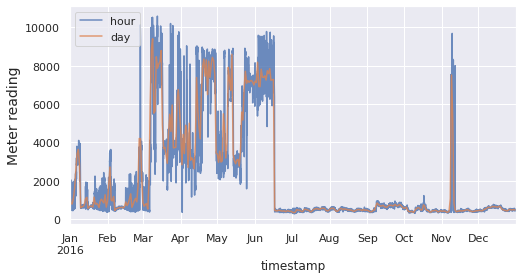

In [29]:
fig, axes = plt.subplots(figsize=(8, 4))
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='hour', alpha=0.8).set_ylabel('Meter reading', fontsize=14)
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='day', alpha=0.8).set_ylabel('Meter reading', fontsize=14)
axes.legend()

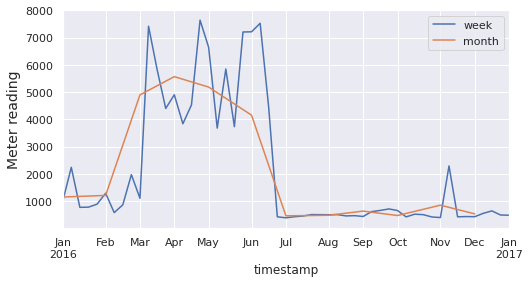

In [30]:
fig, axes = plt.subplots(figsize=(8, 4))
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('W').mean()['meter_reading'].plot(ax=axes, label='week', alpha=1).set_ylabel('Meter reading', fontsize=14)
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('M').mean()['meter_reading'].plot(ax=axes, label='month', alpha=1).set_ylabel('Meter reading', fontsize=14)
axes.legend()

# Outliers

In [31]:
def to_season(month_num):
    season = 'winter'
    if 3 <= month_num <= 5:
        season = 'spring'
    elif 6 <= month_num <= 8:
        season = 'summer'
    elif 9 <= month_num <= 11:
        season = 'autumn'
    return season

In [32]:
train['month'] = train['timestamp'].dt.month
train['season'] = train['month'].apply(lambda x: to_season(x))

In [33]:
train = train.drop(train[(train['meter'] == 0) & (train['meter_reading'] == 0)].index, axis=0)

In [34]:
train = train.drop(train[(train['meter'] == 1) & (train['meter_reading'] == 0) & (train['season'] == 'spring')].index, axis=0)
train = train.drop(train[(train['meter'] == 1) & (train['meter_reading'] == 0) & (train['season'] == 'summer')].index, axis=0)
train = train.drop(train[(train['meter'] == 1) & (train['meter_reading'] == 0) & (train['season'] == 'autumn')].index, axis=0)

In [35]:
train = train.drop(train[(train['meter'] == 2) & (train['meter_reading'] == 0) & (train['season'] == 'spring')].index, axis=0)
train = train.drop(train[(train['meter'] == 2) & (train['meter_reading'] == 0) & (train['season'] == 'autumn')].index, axis=0)
train = train.drop(train[(train['meter'] == 2) & (train['meter_reading'] == 0) & (train['season'] == 'winter')].index, axis=0)

In [36]:
train = train.drop(train[(train['meter'] == 3) & (train['meter_reading'] == 0) & (train['season'] == 'spring')].index, axis=0)
train = train.drop(train[(train['meter'] == 3) & (train['meter_reading'] == 0) & (train['season'] == 'autumn')].index, axis=0)
train = train.drop(train[(train['meter'] == 3) & (train['meter_reading'] == 0) & (train['season'] == 'winter')].index, axis=0)

In [37]:
train = train.drop('season', axis=1).reset_index(drop=True)
gc.collect()

train = reduce_mem_usage(train)

Memory usage of dataframe is 1043.12 MB
Memory usage after optimization is: 611.48 MB
Decreased by 41.4%


In [38]:
print(train.shape)
train.head()

(18858379, 11)


,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,air_temperature,dew_temperature,month
0,46,0,2016-01-01,53.239700,0,Retail,9045,2016.0,25.0,20.0,1
1,74,0,2016-01-01,43.001301,0,Parking,387638,1997.0,25.0,20.0,1
2,93,0,2016-01-01,52.420601,0,Office,33370,1982.0,25.0,20.0,1
3,105,0,2016-01-01,23.303600,1,Education,50623,NaN,3.8,2.4,1
4,106,0,2016-01-01,0.374600,1,Education,5374,NaN,3.8,2.4,1


# Feature Engineering

In [39]:
train['hour'] = train['timestamp'].dt.hour
#train['day'] = train['timestamp'].dt.day
#train['weekend'] = train['timestamp'].dt.weekday

In [40]:
train = train.drop(['timestamp', 'site_id'], axis=1)
gc.collect()

train = reduce_mem_usage(train)

Memory usage of dataframe is 593.50 MB
Memory usage after optimization is: 467.60 MB
Decreased by 21.2%


In [41]:
df_group = train.groupby('building_id')['meter_reading']

building_mean = df_group.mean()
building_median = df_group.median()
building_std = df_group.std()

building_min = df_group.min()
building_max = df_group.max()

In [42]:
train['building_mean'] = train['building_id'].map(building_mean)
train['building_median'] = train['building_id'].map(building_median)
train['building_std'] = train['building_id'].map(building_std)

train['building_min'] = train['building_id'].map(building_min)
train['building_max'] = train['building_id'].map(building_max)

In [43]:
del df_group
gc.collect()

train = reduce_mem_usage(train)

Memory usage of dataframe is 899.24 MB
Memory usage after optimization is: 827.30 MB
Decreased by 8.0%


In [44]:
print(train.shape)
train.head()

(18858379, 15)


,building_id,meter,meter_reading,primary_use,square_feet,year_built,air_temperature,dew_temperature,month,hour,building_mean,building_median,building_std,building_min,building_max
0,46,0,53.239700,Retail,9045,2016.0,25.0,20.0,1,0,15.850802,12.789499,12.523717,0.4095,283.000000
1,74,0,43.001301,Parking,387638,1997.0,25.0,20.0,1,0,128.057907,109.551003,41.993210,16.7227,268.000000
2,93,0,52.420601,Office,33370,1982.0,25.0,20.0,1,0,165.691940,161.240997,39.328667,1.4982,396.000000
3,105,0,23.303600,Education,50623,NaN,3.8,2.4,1,0,78.124031,75.115097,27.533489,23.3036,173.945007
4,106,0,0.374600,Education,5374,NaN,3.8,2.4,1,0,4.004444,0.749200,5.811982,0.0000,40.000000


# Preprocess

In [45]:
# drop_col = ['precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed', 'floor_count']      

In [46]:
# train = train.drop(drop_col, axis = 1)
# gc.collect()

In [47]:
train['square_feet'] = np.log(train['square_feet'])
test['square_feet'] = np.log(test['square_feet'])

In [48]:
le = LabelEncoder()

train['primary_use'] = le.fit_transform(train['primary_use'])
test['primary_use'] = le.fit_transform(test['primary_use'])

In [49]:
target = np.log1p(train['meter_reading'])
train = train.drop(['meter_reading'], axis=1)

In [50]:
del le
gc.collect()

140

In [51]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 953.19 MB
Memory usage after optimization is: 755.36 MB
Decreased by 20.8%
Memory usage of dataframe is 2425.72 MB
Memory usage after optimization is: 1312.28 MB
Decreased by 45.9%


In [52]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [53]:
print(sys.getsizeof(train))
print(sys.getsizeof(test))

792052078
1376020960


In [54]:
print(train.shape)
train.head()

(18858379, 14)


,building_id,meter,primary_use,square_feet,year_built,air_temperature,dew_temperature,month,hour,building_mean,building_median,building_std,building_min,building_max
0,46,0,11,9.109967,2016.0,25.0,20.0,1,0,15.850802,12.789499,12.523717,0.4095,283.000000
1,74,0,8,12.867827,1997.0,25.0,20.0,1,0,128.057907,109.551003,41.993210,16.7227,268.000000
2,93,0,6,10.415413,1982.0,25.0,20.0,1,0,165.691940,161.240997,39.328667,1.4982,396.000000
3,105,0,0,10.832161,NaN,3.8,2.4,1,0,78.124031,75.115097,27.533489,23.3036,173.945007
4,106,0,0,8.589328,NaN,3.8,2.4,1,0,4.004444,0.749200,5.811982,0.0000,40.000000


# Modeling

In [55]:
'''
X_tr, X_val, y_tr, y_val = train_test_split(train, target, test_size=0.2, random_state=666)

def create_model(trial):
    num_leaves = trial.suggest_int('num_leaves', 2, 30)
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    min_child_samples = trial.suggest_int('min_child_samples', 100, 1200)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 5, 90)
    bagging_freq = trial.suggest_int('bagging_freq', 1, 7)
    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.0001, 1.0)
    feature_fraction = trial.suggest_uniform('feature_fraction', 0.0001, 1.0)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    
    model = lgb.LGBMRegressor(
        num_leaves=num_leaves,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth, 
        min_child_samples=min_child_samples, 
        min_data_in_leaf=min_data_in_leaf,
        bagging_freq=bagging_freq,
        bagging_fraction=bagging_fraction,
        feature_fraction=feature_fraction,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        metric='rsme',
        random_state=666)
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)
    rsme = np.sqrt(mean_squared_error(y_pred, y_val))
    return rsme

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40)
params = study.best_params
print(params)
'''

"\nX_tr, X_val, y_tr, y_val = train_test_split(train, target, test_size=0.2, random_state=666)\n\ndef create_model(trial):\n    num_leaves = trial.suggest_int('num_leaves', 2, 30)\n    n_estimators = trial.suggest_int('n_estimators', 50, 300)\n    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)\n    max_depth = trial.suggest_int('max_depth', 2, 10)\n    min_child_samples = trial.suggest_int('min_child_samples', 100, 1200)\n    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 5, 90)\n    bagging_freq = trial.suggest_int('bagging_freq', 1, 7)\n    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.0001, 1.0)\n    feature_fraction = trial.suggest_uniform('feature_fraction', 0.0001, 1.0)\n    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)\n    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)\n    \n    model = lgb.LGBMRegressor(\n        num_leaves=num_leaves,\n        n_estimators=n_estimators,\n        learning_rate

In [56]:
params = {'num_leaves': 30,
          'n_estimators': 279,
          'learning_rate': 0.41293292317272395,
          'max_depth': 9,
          'min_child_samples': 118,
          'min_data_in_leaf': 74,
          'bagging_freq': 1,
          'bagging_fraction': 0.34909235383110854,
          'feature_fraction': 0.7673641507626504,
          'subsample': 0.7826605676058075,
          'colsample_bytree': 0.31499443536061944,
          'random_state': 666}

In [57]:
cls = lgb.LGBMRegressor(**params)
cls.fit(train, target)

[LightGBM] [Warning] bagging_fraction is set=0.34909235383110854, subsample=0.7826605676058075 will be ignored. Current value: bagging_fraction=0.34909235383110854
[LightGBM] [Warning] feature_fraction is set=0.7673641507626504, colsample_bytree=0.31499443536061944 will be ignored. Current value: feature_fraction=0.7673641507626504
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=118 will be ignored. Current value: min_data_in_leaf=74


LGBMRegressor(bagging_fraction=0.34909235383110854, bagging_freq=1,
              colsample_bytree=0.31499443536061944,
              feature_fraction=0.7673641507626504,
              learning_rate=0.41293292317272395, max_depth=9,
              min_child_samples=118, min_data_in_leaf=74, n_estimators=279,
              num_leaves=30, random_state=666, subsample=0.7826605676058075)

In [58]:
del train, target, params
gc.collect()

119

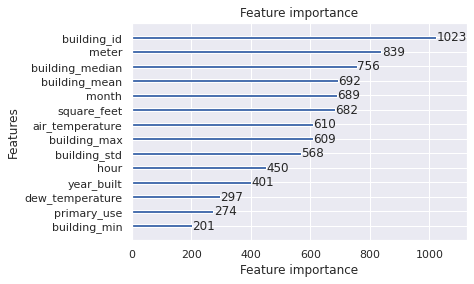

In [59]:
lgb.plot_importance(cls)
plt.show()

# Submit

In [60]:
row_id = test['row_id']

test = test.drop(['row_id'], axis = 1)
gc.collect()

4979

In [61]:
test['hour'] = test['timestamp'].dt.hour
# test['day'] = test['timestamp'].dt.day
# test['weekend'] = test['timestamp'].dt.weekday
test['month'] = test['timestamp'].dt.month

In [62]:
test = test.drop(['timestamp', 'site_id'], axis=1)
gc.collect()

55

In [63]:
test['building_mean'] = test['building_id'].map(building_mean)
test['building_median'] = test['building_id'].map(building_median)
test['building_std'] = test['building_id'].map(building_std)

test['building_min'] = test['building_id'].map(building_min)
test['building_max'] = test['building_id'].map(building_max)

In [64]:
del building_mean, building_median, building_std
gc.collect()

40

In [65]:
row_id = row_id.reset_index(drop=True)
test = test.reset_index(drop=True)

test = reduce_mem_usage(test)

Memory usage of dataframe is 2385.96 MB
Memory usage after optimization is: 1670.17 MB
Decreased by 30.0%


In [66]:
print(pd.DataFrame([[i for i in dir()], [sys.getsizeof(eval(i)) for i in dir()]],
                   index=['name','size']).T.sort_values('size', ascending=False).reset_index(drop=True).head(10))

           name        size
0          test  1751299360
1        row_id   166790560
2  building_min       50484
3  building_max       50484
4           _22        2437
5           _15        2349
6           _13        2309
7           _44        2077
8           _38        2017
9          _i11        1787


In [67]:
print(test.shape)
test.head()

(41697600, 14)


,building_id,meter,primary_use,square_feet,year_built,air_temperature,dew_temperature,hour,month,building_mean,building_median,building_std,building_min,building_max
0,0,0,0,8.913550,2008.0,17.799999,11.7,0,1,237.749130,240.944000,49.132168,37.540798,448.000000
1,1,0,0,7.908387,2004.0,17.799999,11.7,0,1,118.553741,131.871002,29.347374,11.740000,255.000000
2,2,0,0,8.589700,1991.0,17.799999,11.7,0,1,23.626499,20.476801,14.302269,1.228600,67.983002
3,3,0,0,10.072598,2002.0,17.799999,11.7,0,1,382.736023,368.924011,112.268532,77.811897,937.000000
4,4,0,0,11.666565,1975.0,17.799999,11.7,0,1,1579.174194,1593.780029,176.969437,70.986298,3592.000000


In [68]:
target = np.expm1(cls.predict(test))

submission = pd.DataFrame(target, index=row_id, columns=['meter_reading'])
submission.head(10)

,meter_reading
row_id,
0,39.108085
1,51.360983
2,8.794303
3,95.236591
4,288.396315
5,10.192141
6,25.039492
7,148.996264
8,20.136699


In [69]:
del row_id
gc.collect()

submission = reduce_mem_usage(submission)

Memory usage of dataframe is 636.25 MB
Memory usage after optimization is: 477.19 MB
Decreased by 25.0%


In [70]:
submission.to_csv('ASHRAE_submit.csv')